# Noise Removal

Load a picture as a 3-dimensional `np.array`

In [1]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# write here the import path of the image
# test this with
# - TarantulaNebula
# - mondrian
# - mondrian (rotated)
image_path = "./mondrian.jpg"
A = imread(image_path)
# A = rotate(A, 20, reshape=False)


Transform the image in gray-scale and add random noise

In [2]:
X = np.mean(A, axis=2) / A.max()
gamma = 0.1
X_noisy = X + gamma * np.random.randn(*X.shape)
X_noisy = np.clip(X_noisy, 0, 1)

Plot the original image and the noisy one

Text(0.5, 1.0, 'Noisy Image')

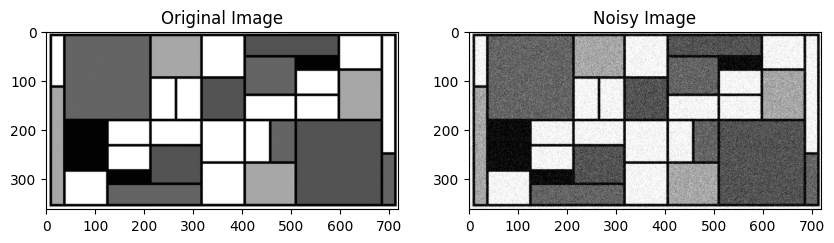

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(X, cmap="gray")
axs[0].set_title("Original Image")
axs[1].imshow(X_noisy, cmap="gray")
axs[1].set_title("Noisy Image")

Compute and visualize the threshold for denoising with:
- optimal hard threshold 
$$(4 / \sqrt{3})\sqrt{n} \gamma$$
- optimal hard threshold with unknown noise (slide 7, NAML_Lect300925_v2)
$$\tau = \omega(\beta) \sigma_{median}$$
$$\omega(\beta) \sim 0.56 \beta^3 - 0.95 \beta^2 + 1.82 \beta + 1.43, \quad \beta = m / n$$
- 90% energy (0.9 of cumulative sum)

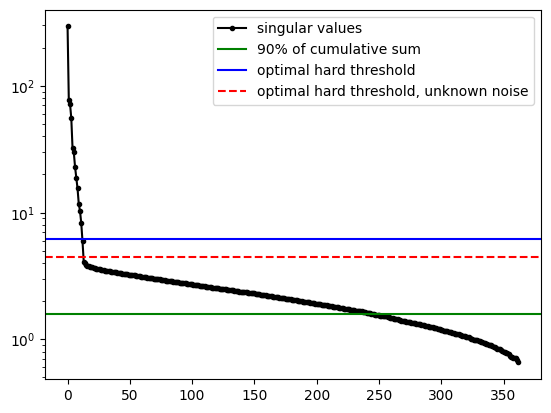

In [4]:
U, s, VT = np.linalg.svd(X_noisy, full_matrices=0)

# SOLUTION-BEGIN
# Truncate using optimal hard threshold
# the aspect ratio is not too distorted, we use the formula for the square
m, n = X.shape
cutoff = (4 / np.sqrt(3)) * np.sqrt(n) * gamma

# Truncate to keep 90% of cumulative sum
cumsum_thrshold = 0.90
cdS = np.cumsum(s) / np.sum(s)
r90 = np.min(np.where(cdS > cumsum_thrshold))
cutoff90 = s[r90]

# Supposing unknown noise
sigma_med = np.median(s)
beta = m / n
omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
cutoff_unknown = omega * sigma_med

plt.semilogy(s, "k.-", label="singular values")
plt.axhline(s[r90], color="g", label="90% of cumulative sum")
plt.axhline(cutoff, color="b", label="optimal hard threshold")
plt.axhline(
    cutoff_unknown,
    color="r",
    linestyle="--",
    label="optimal hard threshold, unknown noise",
)

plt.legend()
# SOLUTION-END

Compute the de-noised images with the previous thresholds

In [5]:
# SOLUTION-BEGIN
def denoise(U, s, VT, threshold):
  r = np.max(np.where(s > threshold))
  return U[:, : (r + 1)] @ np.diag(s[: (r + 1)]) @ VT[: (r + 1), :]

Xclean = denoise(U, s, VT, cutoff)
X90 = denoise(U, s, VT, cutoff90)
# SOLUTION-END

Plot and compare the denoised images. Plot also the error with respect to the original image.

Text(0.5, 1.0, 'Error: (4.26e+01)')

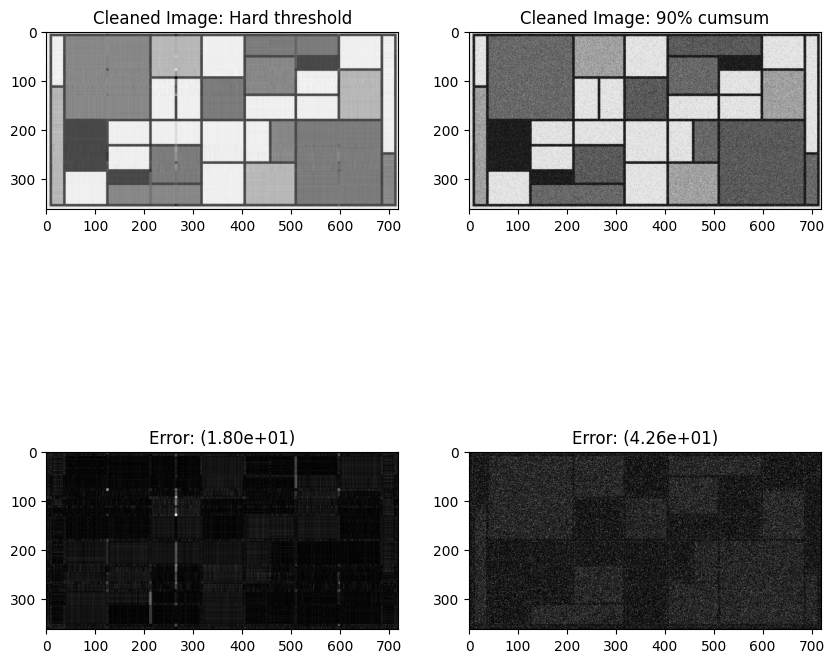

In [6]:
# SOLUTION-BEGIN
err_clean = np.abs(X - Xclean)
err_90 = np.abs(X - X90)
err_norm_clean = np.linalg.norm(err_clean, ord="fro")
err_norm_90 = np.linalg.norm(err_90, ord="fro")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(Xclean, cmap="gray")
axs[0, 0].set_title("Cleaned Image: Hard threshold")
axs[0, 1].imshow(X90, cmap="gray")
axs[0, 1].set_title("Cleaned Image: 90% cumsum")

max_err = max([err_clean.max(), err_90.max()])
axs[1, 0].imshow(err_clean, cmap="gray", vmin=0, vmax=max_err)
axs[1, 0].set_title(f"Error: ({err_norm_clean:.2e})")
axs[1, 1].imshow(err_90, cmap="gray", vmin=0, vmax=max_err)
axs[1, 1].set_title(f"Error: ({err_norm_90:.2e})")
# SOLUTION-END